In [1]:
# Load datasets
import pandas as pd

chess_df = pd.read_csv('/kaggle/input/chess-dataset/chessData.csv')
random_df = pd.read_csv('/kaggle/input/chess-dataset/random_evals.csv')

print("chess_df shape:", chess_df.shape)
print("random_df shape:", random_df.shape)
chess_df.head()

chess_df shape: (12958035, 2)
random_df shape: (1000273, 2)


,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26


In [2]:
# Clean evaluation values
def clean_evaluations(series):
    def to_float(val):
        try:
            val = str(val).strip()
            if val.startswith("#"):
                return 10000.0 if "+" in val else -10000.0
            return float(val)
        except:
            return np.nan
    return series.map(to_float)

In [3]:
# FEN feature extractor 
def fen_to_features(fen):
    try:
        fields = fen.strip().split()
        board_str, active, castling = fields[0], fields[1], fields[2]
    except:
        return None

    piece_counts = {c: 0 for c in 'PNBRQKpnbrqk'}
    board_rows = board_str.split('/')
    board_grid = []
    for row in board_rows:
        expanded = []
        for ch in row:
            if ch.isdigit():
                expanded += ['.'] * int(ch)
            else:
                expanded.append(ch)
        board_grid.append(expanded)

    for row in board_grid:
        for ch in row:
            if ch in piece_counts:
                piece_counts[ch] += 1

    values = {'P':1,'N':3,'B':3,'R':5,'Q':9,'p':1,'n':3,'b':3,'r':5,'q':9}
    white_mat = sum(piece_counts[c] * values[c] for c in 'PNBRQ')
    black_mat = sum(piece_counts[c] * values[c] for c in 'pnbrq')
    material_balance = white_mat - black_mat

    def is_king_castled(color):
        row = 7 if color == 'w' else 0
        for col in range(8):
            if board_grid[row][col] == ('K' if color == 'w' else 'k'):
                return int(col in [6, 2])
        return 0

    white_king_castled = is_king_castled('w')
    black_king_castled = is_king_castled('b')

    white_pawn_ranks = [7 - i for i in range(8) for j in range(8) if board_grid[i][j] == 'P']
    black_pawn_ranks = [i for i in range(8) for j in range(8) if board_grid[i][j] == 'p']
    pawn_adv_white = sum(white_pawn_ranks) / len(white_pawn_ranks) if white_pawn_ranks else 2
    pawn_adv_black = sum(black_pawn_ranks) / len(black_pawn_ranks) if black_pawn_ranks else 2

    white_queen_central = any(board_grid[r][c] == 'Q' for r in range(8) for c in [3, 4])
    black_queen_central = any(board_grid[r][c] == 'q' for r in range(8) for c in [3, 4])

    center_squares = [(3,3), (3,4), (4,3), (4,4)]
    center_control_white = sum(1 for r, c in center_squares if board_grid[r][c].isupper())
    center_control_black = sum(1 for r, c in center_squares if board_grid[r][c].islower())

    return {
        **{f"cnt_{p}": piece_counts[p] for p in piece_counts},
        "material_balance": material_balance,
        "active_white": int(active == 'w'),
        "castle_wk": int('K' in castling),
        "castle_wq": int('Q' in castling),
        "castle_bk": int('k' in castling),
        "castle_bq": int('q' in castling),
        "white_king_castled": white_king_castled,
        "black_king_castled": black_king_castled,
        "pawn_advancement_white": pawn_adv_white,
        "pawn_advancement_black": pawn_adv_black,
        "queen_central_white": int(white_queen_central),
        "queen_central_black": int(black_queen_central),
        "center_control_white": center_control_white,
        "center_control_black": center_control_black
    }


In [6]:
from joblib import Parallel, delayed

# Fixed parallelized preprocessing function
def df_to_clean_feature_df_parallel(df, chunk_size=200_000, n_jobs=-1):
    feats_list, labs_list = [], []
    for start in range(0, len(df), chunk_size):
        chunk = df.iloc[start:start + chunk_size]

        # Run FEN parsing in parallel with index tracking
        fen_feats = [
            (i, fen_to_features(fen)) for i, fen in chunk["FEN"].items()
        ]
        fen_feats = [(i, f) for i, f in fen_feats if f is not None]

        if not fen_feats:
            continue

        indices, feature_dicts = zip(*fen_feats)
        feats = pd.DataFrame(feature_dicts, index=indices)

        raw_evals = chunk.loc[feats.index, "Evaluation"]
        cleaned_evals = clean_evaluations(raw_evals).dropna()

        feats = feats.loc[cleaned_evals.index]
        feats_list.append(feats)
        labs_list.append(cleaned_evals)

    X = pd.concat(feats_list, ignore_index=True)
    y = pd.concat(labs_list, ignore_index=True)
    return X, y

# Run preprocessing on both datasets
print("Processing training data...")
X_train, y_train = df_to_clean_feature_df_parallel(chess_df)

print("Processing test data...")
X_test, y_test = df_to_clean_feature_df_parallel(random_df)

# Clip evaluations to reasonable range and convert to pawn units
y_train = y_train.clip(-1000, 1000) / 100.0
y_test  = y_test.clip(-1000, 1000) / 100.0

# Save preprocessed data for reuse
X_train.to_csv("/kaggle/working/X_train.csv", index=False)
y_train.to_csv("/kaggle/working/y_train.csv", index=False)
X_test.to_csv("/kaggle/working/X_test.csv", index=False)
y_test.to_csv("/kaggle/working/y_test.csv", index=False)

print("✅ Preprocessing complete and saved to CSV.")


Processing training data...
Processing test data...
✅ Preprocessing complete and saved to CSV.


In [8]:
# Scale features and transform labels
import numpy as np
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Log transform clipped target values
y_train_clipped = y_train.clip(-5.0, 5.0)
y_test_clipped  = y_test.clip(-5.0, 5.0)

y_train_log = np.sign(y_train_clipped) * np.log1p(np.abs(y_train_clipped))
y_test_log  = np.sign(y_test_clipped) * np.log1p(np.abs(y_test_clipped))


Training LightGBM model...
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.945926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 12958035, number of used features: 24
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Start training from score 0.155566
Training complete.
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
RMSE: 3.06 pawns
R² Score: 0.3529
Model saved to /kaggle/w

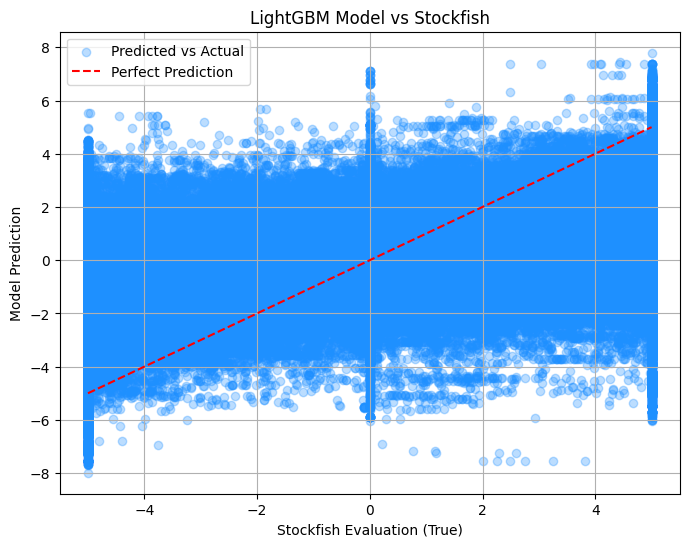

In [9]:
# Train LightGBM model
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

model = LGBMRegressor(
    n_estimators=1500,
    learning_rate=0.01,
    max_depth=10,
    num_leaves=128,
    min_data_in_leaf=50,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

print("Training LightGBM model...")
model.fit(
    X_train_scaled, y_train_log,
    eval_set=[(X_test_scaled, y_test_log)],
    eval_metric="rmse",
    callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
)
print("Training complete.")

# Predict
y_pred_log = model.predict(X_test_scaled)
y_pred = np.sign(y_pred_log) * np.expm1(np.abs(y_pred_log))

# Metrics
rmse = np.sqrt(mean_squared_error(y_test_clipped, y_pred))
r2 = r2_score(y_test_clipped, y_pred)
print(f"RMSE: {rmse:.2f} pawns")
print(f"R² Score: {r2:.4f}")

# Save model
joblib.dump(model, "/kaggle/working/lgbm_model.joblib")
print("Model saved to /kaggle/working/lgbm_model.joblib")

# Accuracy within ±1 pawn
accuracy = (np.abs(y_test_clipped - y_pred) <= 1.0).mean()
print(f"Accuracy within ±1.0 pawn: {accuracy * 100:.2f}%")

# Plot predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test_clipped, y_pred, alpha=0.3, color='dodgerblue', label="Predicted vs Actual")
plt.plot([-5, 5], [-5, 5], color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel("Stockfish Evaluation (True)")
plt.ylabel("Model Prediction")
plt.title("LightGBM Model vs Stockfish")
plt.legend()
plt.grid(True)
plt.show()
